<a href="https://colab.research.google.com/github/Hsuli0607/ML/blob/main/Classification_I_Detecting_Poor_Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import re
from collections import defaultdict
from tqdm.notebook import tqdm
!pip install ujson
import ujson as json

# put posts.xml in the DATA_DIR
DATA_DIR = r'/content/drive/My Drive/stackoverflow'
YEAR = 2017
fn_posts_all = os.path.join(DATA_DIR,'Posts.xml')
fn_posts = os.path.join(DATA_DIR, 'posts-%i.xml' % YEAR)
# the above line of code can be concised to : fn_posts = os.path.join(DATA_DIR, 'posts-{YEAR}.xml')

fn_filtered = os.path.join(DATA_DIR, f'filtered-{YEAR}.tsv')
fn_filtered_meta = os.path.join(DATA_DIR, f'filtered-{YEAR}-meta.tsv')

#Make dirs if they are not exist
SAMPLE_DIR = rf'{DATA_DIR}/{YEAR}'
if not os.path.exists(SAMPLE_DIR):
  os.mkdir(SAMPLE_DIR)
if not os.path.exists(os.path.join(SAMPLE_DIR,'data')):
  os.mkdir(os.path.join(SAMPLE_DIR,'data'))

fn_sample = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', 'sample-meta.tsv'))
fn_sample_meta = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', 'sample-meta.json'))
print('sample posts: %s' % fn_sample)
print('sample meta: %s' % fn_sample_meta)

CHART_DIR = os.path.join(SAMPLE_DIR,'charts')
if not os.path.exists(CHART_DIR):
  os.mkdir(CHART_DIR)

In [ ]:
year_match = re.compile(r'^\s+<row [^>]*CreationDate="(\d+)-')
size = os.path.getsize(fn_posts_all)

# get_year function to get year informaton from file
def get_year(line):
  m = year_match.match(line)
  if m is None:
    return None
  return int(m.group(1))

# the function get the beginning of target year location
def beginning_target_year_search(fa, size, target_year):
    left, right = 0, size
    mid = (left + right) // 2
    delta = mid

    while True:
      fa.seek(mid)
      fa.readline()
      line = fa.readline()
      year = get_year(line)


      if delta == 0:
        break

      if year < target_year:
        left = mid
        delta = (right - left)//2
        mid = (left+right)//2


      elif year >= target_year:
        right = mid
        delta = (right-left)//2
        mid = (left+right)//2


    return mid

print(f'Extracting all posts from {YEAR}')
with open(fn_posts_all, 'r', encoding ='utf-8') as fa, open(fn_posts, 'w', encoding='utf-8') as f_year:
  #first line is the xml hearder and posts tag
  f_year.write ('<?xml version="1.0" encoding="utf-8"?><posts>\n')
  # Write all posts of YEAR
  result = beginning_target_year_search(fa, size, YEAR)

  fa.seek(result)
  fa.readline()
  while True:
    line = fa.readline()
    year = get_year(line)

    if year == YEAR:
      f_year.write(line)
    elif year < YEAR:
      continue
    elif year is None or year > YEAR:
      break
  # write the closing tag
  f_year.write('</posts>')
print('....done!')

Extracting all posts from 2017
....done!


In [ ]:
from dateutil import parser as dateparser
from operator import itemgetter
from lxml import etree

NUM_ROWS = 5113519 #counted by hand

filtered_meta = {
    'question': {}, # question-> [(answer ID, Score), ...]
    'total':0 # questions and answers finally written
    }

# Regular expressions to find code snippets, links, and tags, which might help in
# designing useful features

code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE| re.DOTALL)
link_match = re.compile('<a href="https//.*?".*?>(.*?)</a>',re.MULTILINE|re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE| re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE| re.DOTALL)


This function creates features from the rew post. It already contains all features that we will use thoughout the chapter.

In [ ]:
def extract_features_from_body(s):
  num_code_lines = 0
  link_count_in_code = 0
  code_free_s = s

  # remove source code and count how many lines
  for match_str in code_match.findall(s):
    num_code_lines += match_str.count('\n')
    code_free_s = code_match.sub(' ',code_free_s)
    # sometimes source code contain links, which we don't want to count
    link_count_in_code += len(link_match.findall(match_str))

  links = link_match.findall(s)
  link_count = len(links) - link_count_in_code
  html_free_s=tag_match.sub(' ', code_free_s)
  text = html_free_s
  for link in links:
    if link.lower().startswith('http://'):
      text = text.replace(link, ' ')
  text = whitespace_match.sub(' ', text)
  num_text_tokens = text.count(' ')
  return text, num_text_tokens, num_code_lines, link_count


In [ ]:
num_questions = 0
num_answers = 0

In [ ]:
def parsexml(fn):
  global num_questions, num_answers

  # iterparse() returns a tuple (event, element). Since we request only
  # 'start' events, we pipe the result through an itemgetter that  always returns
  # the 2nd rusult.

  it = map(itemgetter(1), etree.iterparse(fn, events = ('start',)))

  # Get the <posts> element, in which we will parse the <row> elements. While doing so,
  # we will need the root handle to clear memory
  root = next(it)
  counter = 0
  for counter, elem in enumerate(tqdm(it, total = NUM_ROWS)):
    if elem.tag != 'row':
      continue
    Id = int(elem.get('Id'))
    PostTypeId = int(elem.get('PostTypeId'))
    Score = int(elem.get('Score'))

    if PostTypeId == 1:
      num_questions += 1
      ParentId = -1
      filtered_meta['question'][Id] = []
    elif PostTypeId == 2:
      num_answers += 1
      ParentId = int(elem.get('ParentId'))
      if not ParentId in filtered_meta['question']:
        # question is not from the same year so we have already dropped it
        continue
      filtered_meta['question'][ParentId].append((Id, Score))
    else:
      continue

    Text, NumTextTokens, NumCodelines, LinkCount = extract_features_from_body(elem.get('Body'))
      # We have to tell lxml that this element is not used anymore. Otherwise memory will
      # blow up. See httpS://www.ibm.com/developerworks/xml/libraary/x-hiperfparse for more information.
    elem.clear()
    while elem.getprevious() is not None:
      del elem.getparent()[0]

    values = (Id, ParentId, Score, NumTextTokens, NumCodelines, LinkCount, Text)
    # yield values is a generater statement that return a tuple of values from each iteration of the loop.
    # for later use the function in a loop, to be more memory-efficient than build a large list.

    yield values
  print('Found %i posts' % counter)

if any(not os.path.exists(fn) for fn in [fn_filtered, fn_filtered_meta]):
  total = 0
  with open(fn_filtered, 'w', encoding='utf-8') as f:
    for values in parsexml(fn_posts):
      line = '\t'.join(map(str, values))

      f.write(line + '\n')
      total += 1
  filtered_meta['total'] = total

  with open(fn_filtered_meta, 'w', encoding ='utf-8') as f:
    json.dump(filtered_meta, f)
  print('#question: %i' % num_questions)
  print('#answers: %i' % num_answers)

else:
  print('Skipping the conversion step, loading data from %s ...' % fn_filtered_meta)
  filtered_meta = json.load(open(fn_filtered_meta, 'r', encoding = 'utf-8'))
  print('....done!')



Skipping the conversion step, loading data from /content/drive/My Drive/stackoverflow/filtered-2017-meta.tsv ...
....done!


To select the answers that we want to keep per question. Do this in two stages:


1.   Stage 1 : Chosing question that have a postive and negative answer and then chosing the most postive and negative.
2.   Stage 2 : Write out the featur
es for those answers




In [ ]:
NUM_QUESTION_SAMPLE = 10000
posts_to_keep = set()
found_questions = 0

question = filtered_meta['question']

# Sorting the questions before iterating over them is only done for reproducability
for ParentId, posts in tqdm(sorted(question.items()), desc = 'Stage 1:'):
  assert ParentId != -1

  if len(posts) < 2:
    continue
  neg_score_ids = []
  pos_score_ids = []

  for Id, Score in posts:
    if Score < 0 :
      neg_score_ids.append((Score, Id))
    elif Score > 0 :
      pos_score_ids.append((Score, Id))

  if pos_score_ids and neg_score_ids:
    posts_to_keep.add(int(ParentId))

    posScore, posId = sorted(pos_score_ids)[-1]
    posts_to_keep.add(posId)

    negScore, negId = sorted(neg_score_ids)[0]
    posts_to_keep.add(negId)

    found_questions += 1

  if found_questions >= NUM_QUESTION_SAMPLE:
    break


Stage 1::   0%|          | 0/2114089 [00:00<?, ?it/s]

In [ ]:

# no idea why we neeed to define already_written empty set!
from collections import defaultdict
already_written = set()
sample_meta = defaultdict(dict)
# defaultdict is a function, create a dictionary-like object, once to access a key it doesn't exist.
# The key will be created automatically with a default value, in above code, it will provide dictionary
# as the key's value.

total = 0
kept = 0

with open(fn_sample, 'w', encoding = 'utf-8') as f:
  # why don't use total to replace NUM_ROWS ?
  for line in tqdm(open(fn_filtered, 'r', encoding = 'utf-8'), total = NUM_ROWS, desc = 'stage 2:'):
    Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text = line.split('\t')
    Text = Text.strip()
    total += 1


    Id = int(Id)
    if Id in posts_to_keep:
      if Id in already_written:
        print(Id, 'is already written')
        continue

      # select meta info
      post = sample_meta[Id]
      post['ParentId'] = int(ParentId)
      post['Score'] = int(Score)
      post['NumTextTokens'] = int(NumTextTokens)
      post['NumCodeLines'] = int(NumCodeLines)
      post['LinkCount'] = int(LinkCount)
      post['idx'] = kept # index into the TSV file

      if int(ParentId) == -1:
        q = sample_meta[Id]
        if not 'Answers' in q:
          q['Answers'] = []

      else:
        q = sample_meta[int(ParentId)]
        if 'Answers' not in q:
          q['Answers'] = [Id]
        else:
          q['Answers'].append(Id)
      f.writelines('%s\t%s\n' % (Id, Text)) # check if can use write to replace writelines
      kept += 1

with open(fn_sample_meta,'w') as fm:
  json.dump(sample_meta, fm)

print('read:', total)
print('kept:', kept)




stage 2::   0%|          | 0/5113519 [00:00<?, ?it/s]

read: 4624811
kept: 30000


#Utility functions

In [ ]:
# to transfer fn_sample_meta to a normal dictionary meta for later use
def load_meta(fn):
  meta = json.load(open(fn,'r'))

  #JSON only allows string keys, changing that to int
  for key in list(meta.keys()):
    meta[int(key)] = meta[key]
    del meta[key]
  return meta

meta = load_meta(fn_sample_meta)

def save_png(name):
  fn = '%s.png'%name
  plt.savefig(os.path.join(CHART_DIR, fn), bbox_inches='tight')

# Loading the features and labeling them

In [ ]:
import numpy as np
all_answers = sorted ([a for a, v in meta.items() if v['ParentId'] != -1])
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
print(np.unique(Y, return_counts = True))

(array([False,  True]), array([10000, 10000]))


# Creating our first classifier : KNN using only LinkCount as a feature

[0 0 0 ... 0 0 0]


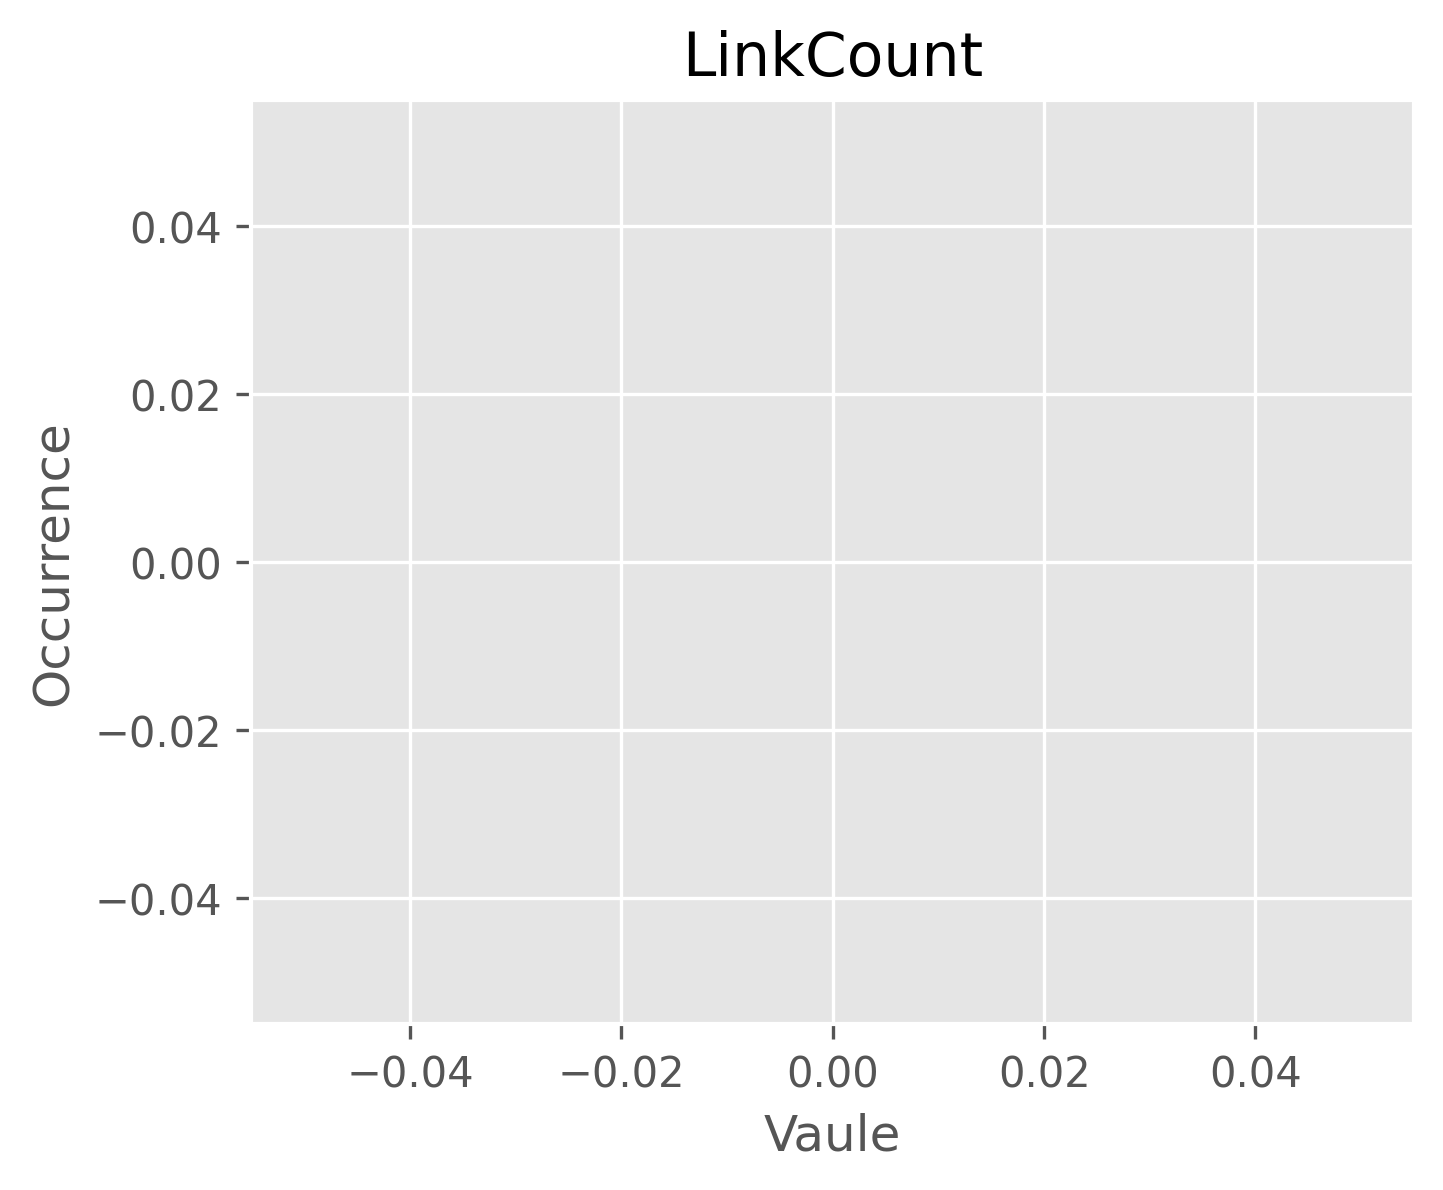

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# create X in one dimension ndarray (dimension is very import!!!)
X = np.asarray([meta[aid]['LinkCount'] for aid in all_answers])
print(X)
plt.figure(figsize=(5,4), dpi=300) # width and height of the plot in inches
plt.title('LinkCount')
plt.xlabel('Vaule')
plt.ylabel('Occurrence')

bin_edges = range(min(X), max(X) + 1)  # Creating a range of bin edges
n, bins, patches = plt.hist(X, normed=1, bins=bin_edges, alpha=0.75)


plt.grid(True)
save_png('01_feat_hist_LinkCount')

# Training on LinkCount

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

N_FOLDS = 10
cv = KFold(n_splits = N_FOLDS, shuffle = True, random_state = 0)

scores = []
for train, test in tqdm(cv.split(X,Y)):
  clf = KNeighborsClassifier()
  clf.fit(X[train].reshape(-1,1), Y[train])
  scores.append(clf.score(X[test].reshape(-1,1), Y[test]))

print('Mean(scores)=%.5f\tStddev(scores)=%.5f'%(np.mean(scores), np.std(scores)))


0it [00:00, ?it/s]

Mean(scores)=0.50120	Stddev(scores)=0.00991


#Using more features

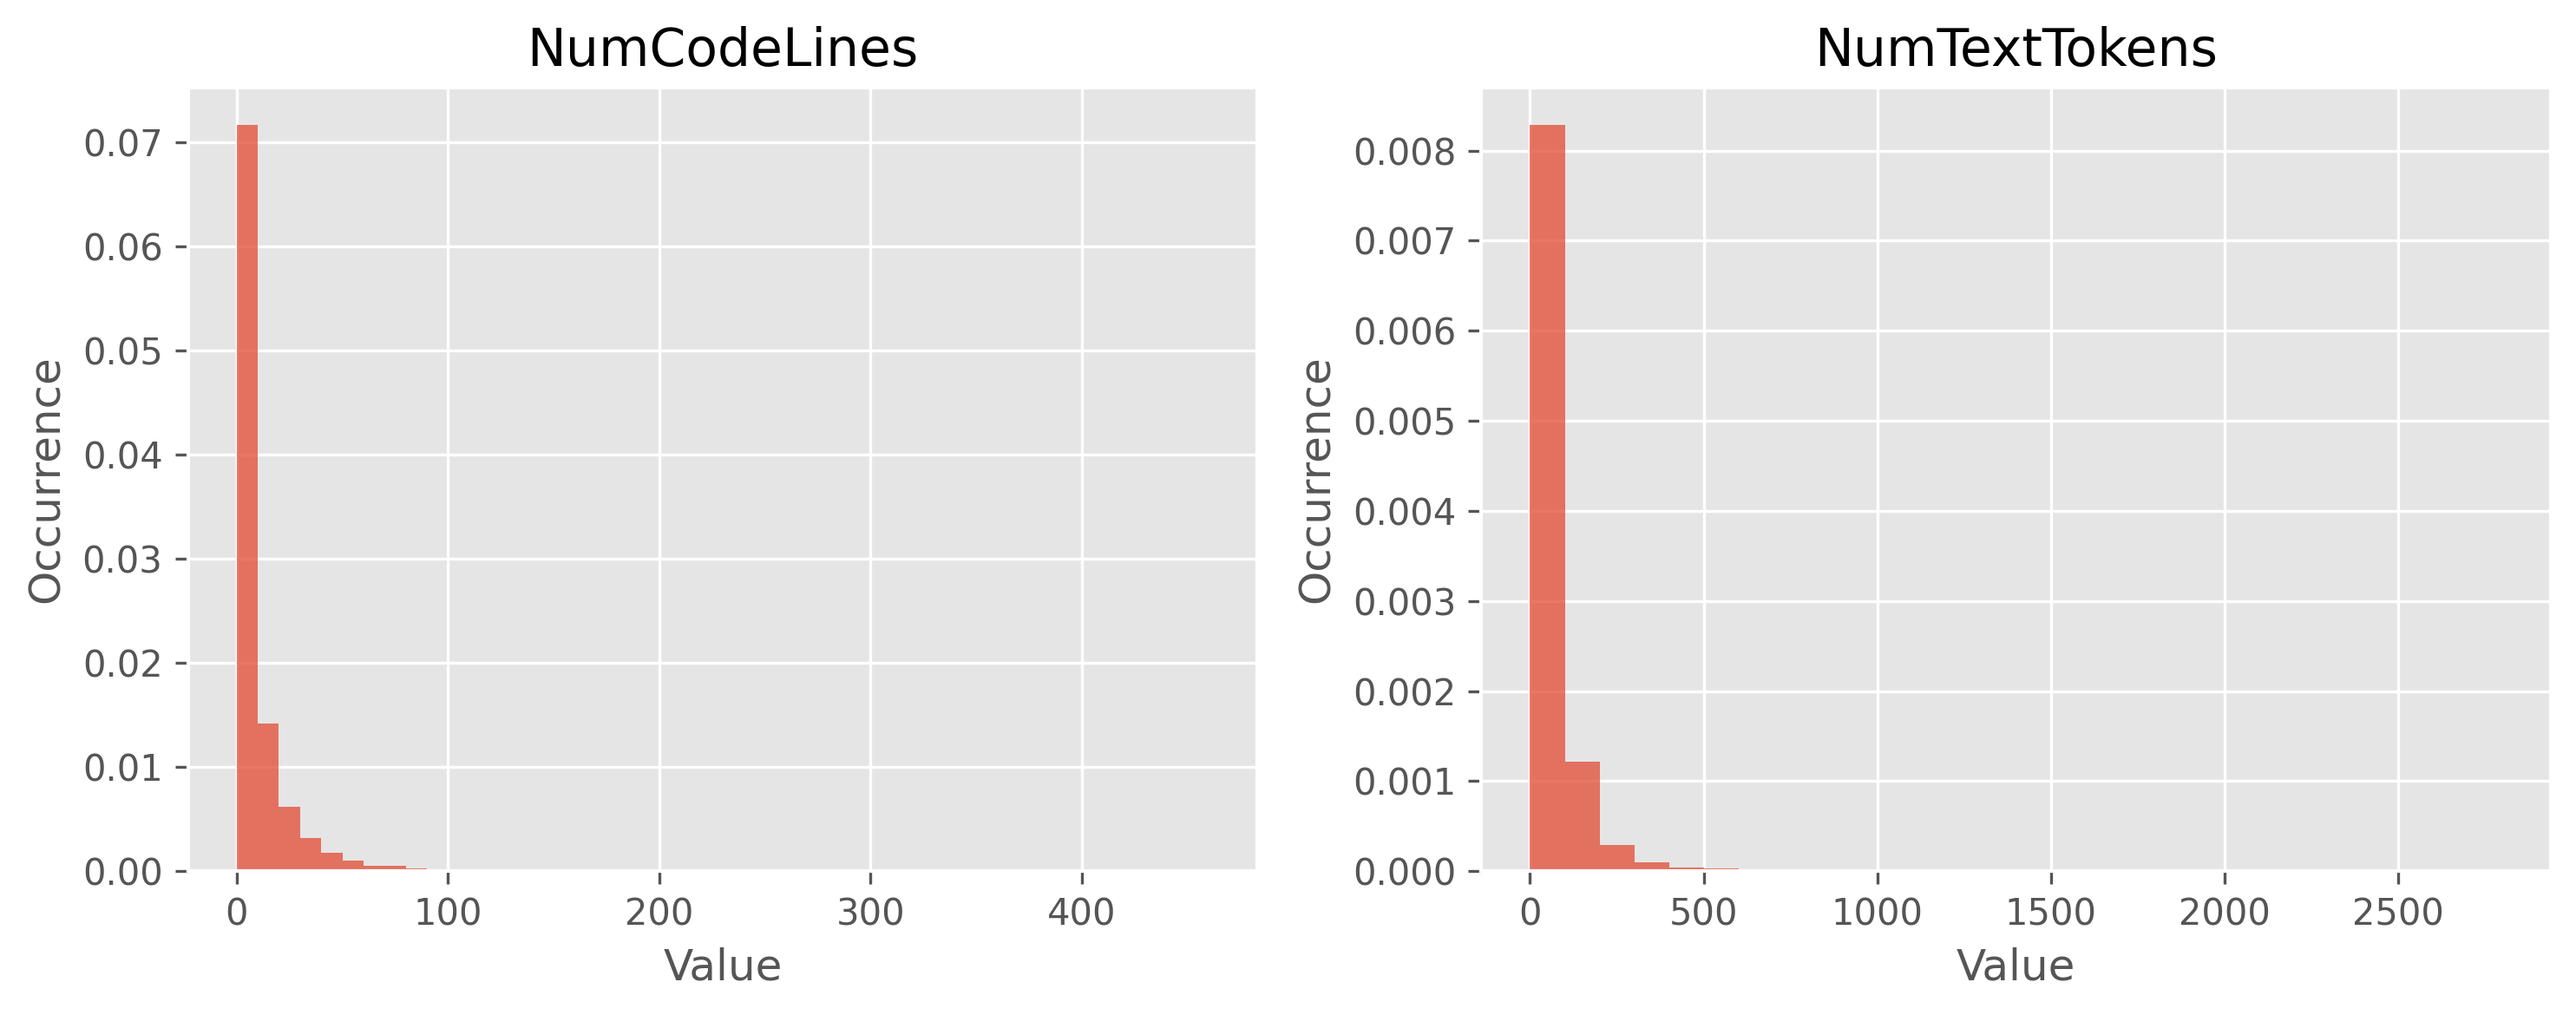

In [ ]:
def plot_feat_hist(data_name_list,filename=None):
  if len(data_name_list) > 1:
    assert filename is not None
  num_rows = int( 1 + (len(data_name_list)-1) / 2)
  num_cols = int(1 if len(data_name_list)== 1 else 2)
  plt.figure(figsize = (5 * num_cols, 4 * num_rows), dpi = 300)

  for i in range(num_rows):
    for j in range(num_cols):
      # plt.subplot(nrows, ncols, index)
      plt.subplot(num_rows, num_cols, 1 + i * num_cols + j)
      x, name = data_name_list[i* num_cols + j]
      plt.title(name)
      plt.xlabel('Value')
      plt.ylabel('Occurrence')

      max_val = np.max(x)
      if max_val > 1000:
        bins = range (0, max_val, 100)
      elif max_val > 100:
        bins = range (0, max_val, 10)
      else:
        bins = range(0, max_val)

      n, bins, patches = plt.hist(x, bins = bins, density = True , alpha = 0.75)

      plt.grid(True)
      plt.tight_layout()

  if not filename:
    filename = 'feat_hist_%s' % name.replace(' ', '_')

  save_png(filename)

plot_feat_hist([(np.asarray([[meta[aid]['NumCodeLines']] for aid in all_answers]), 'NumCodeLines'),
 (np.asarray([[meta[aid]['NumTextTokens']] for aid in all_answers]), 'NumTextTokens')],
               '02_feat_hist_CodeLines_TextTokens')


*** **Since the features vary in their value ranges, we need to staaandardize them using StandardScaler() so that KNN does not bias towards features having larger value intervals.**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_features(aid, feature_names):
  return tuple(meta[aid][fn] for fn in feature_names)
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens'])
for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X,Y), total = N_FOLDS):
  clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
  clf.fit(X[train], Y[train])
  scores.append(clf.score(X[test], Y[test]))

print('Mean(scores)=%.5f\tStddev(scores)=%.5f'%(np.mean(scores), np.std(scores)))

  0%|          | 0/10 [00:00<?, ?it/s]

Mean(scores)=0.59835	Stddev(scores)=0.01093


# Designing more features
let's create some more text based features like average sentence and word length, how many words are CAPITALIZED or contain exclamation marks.
we simply fetch th epost texts, calculate the statistics and add them to the meta dictionary.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


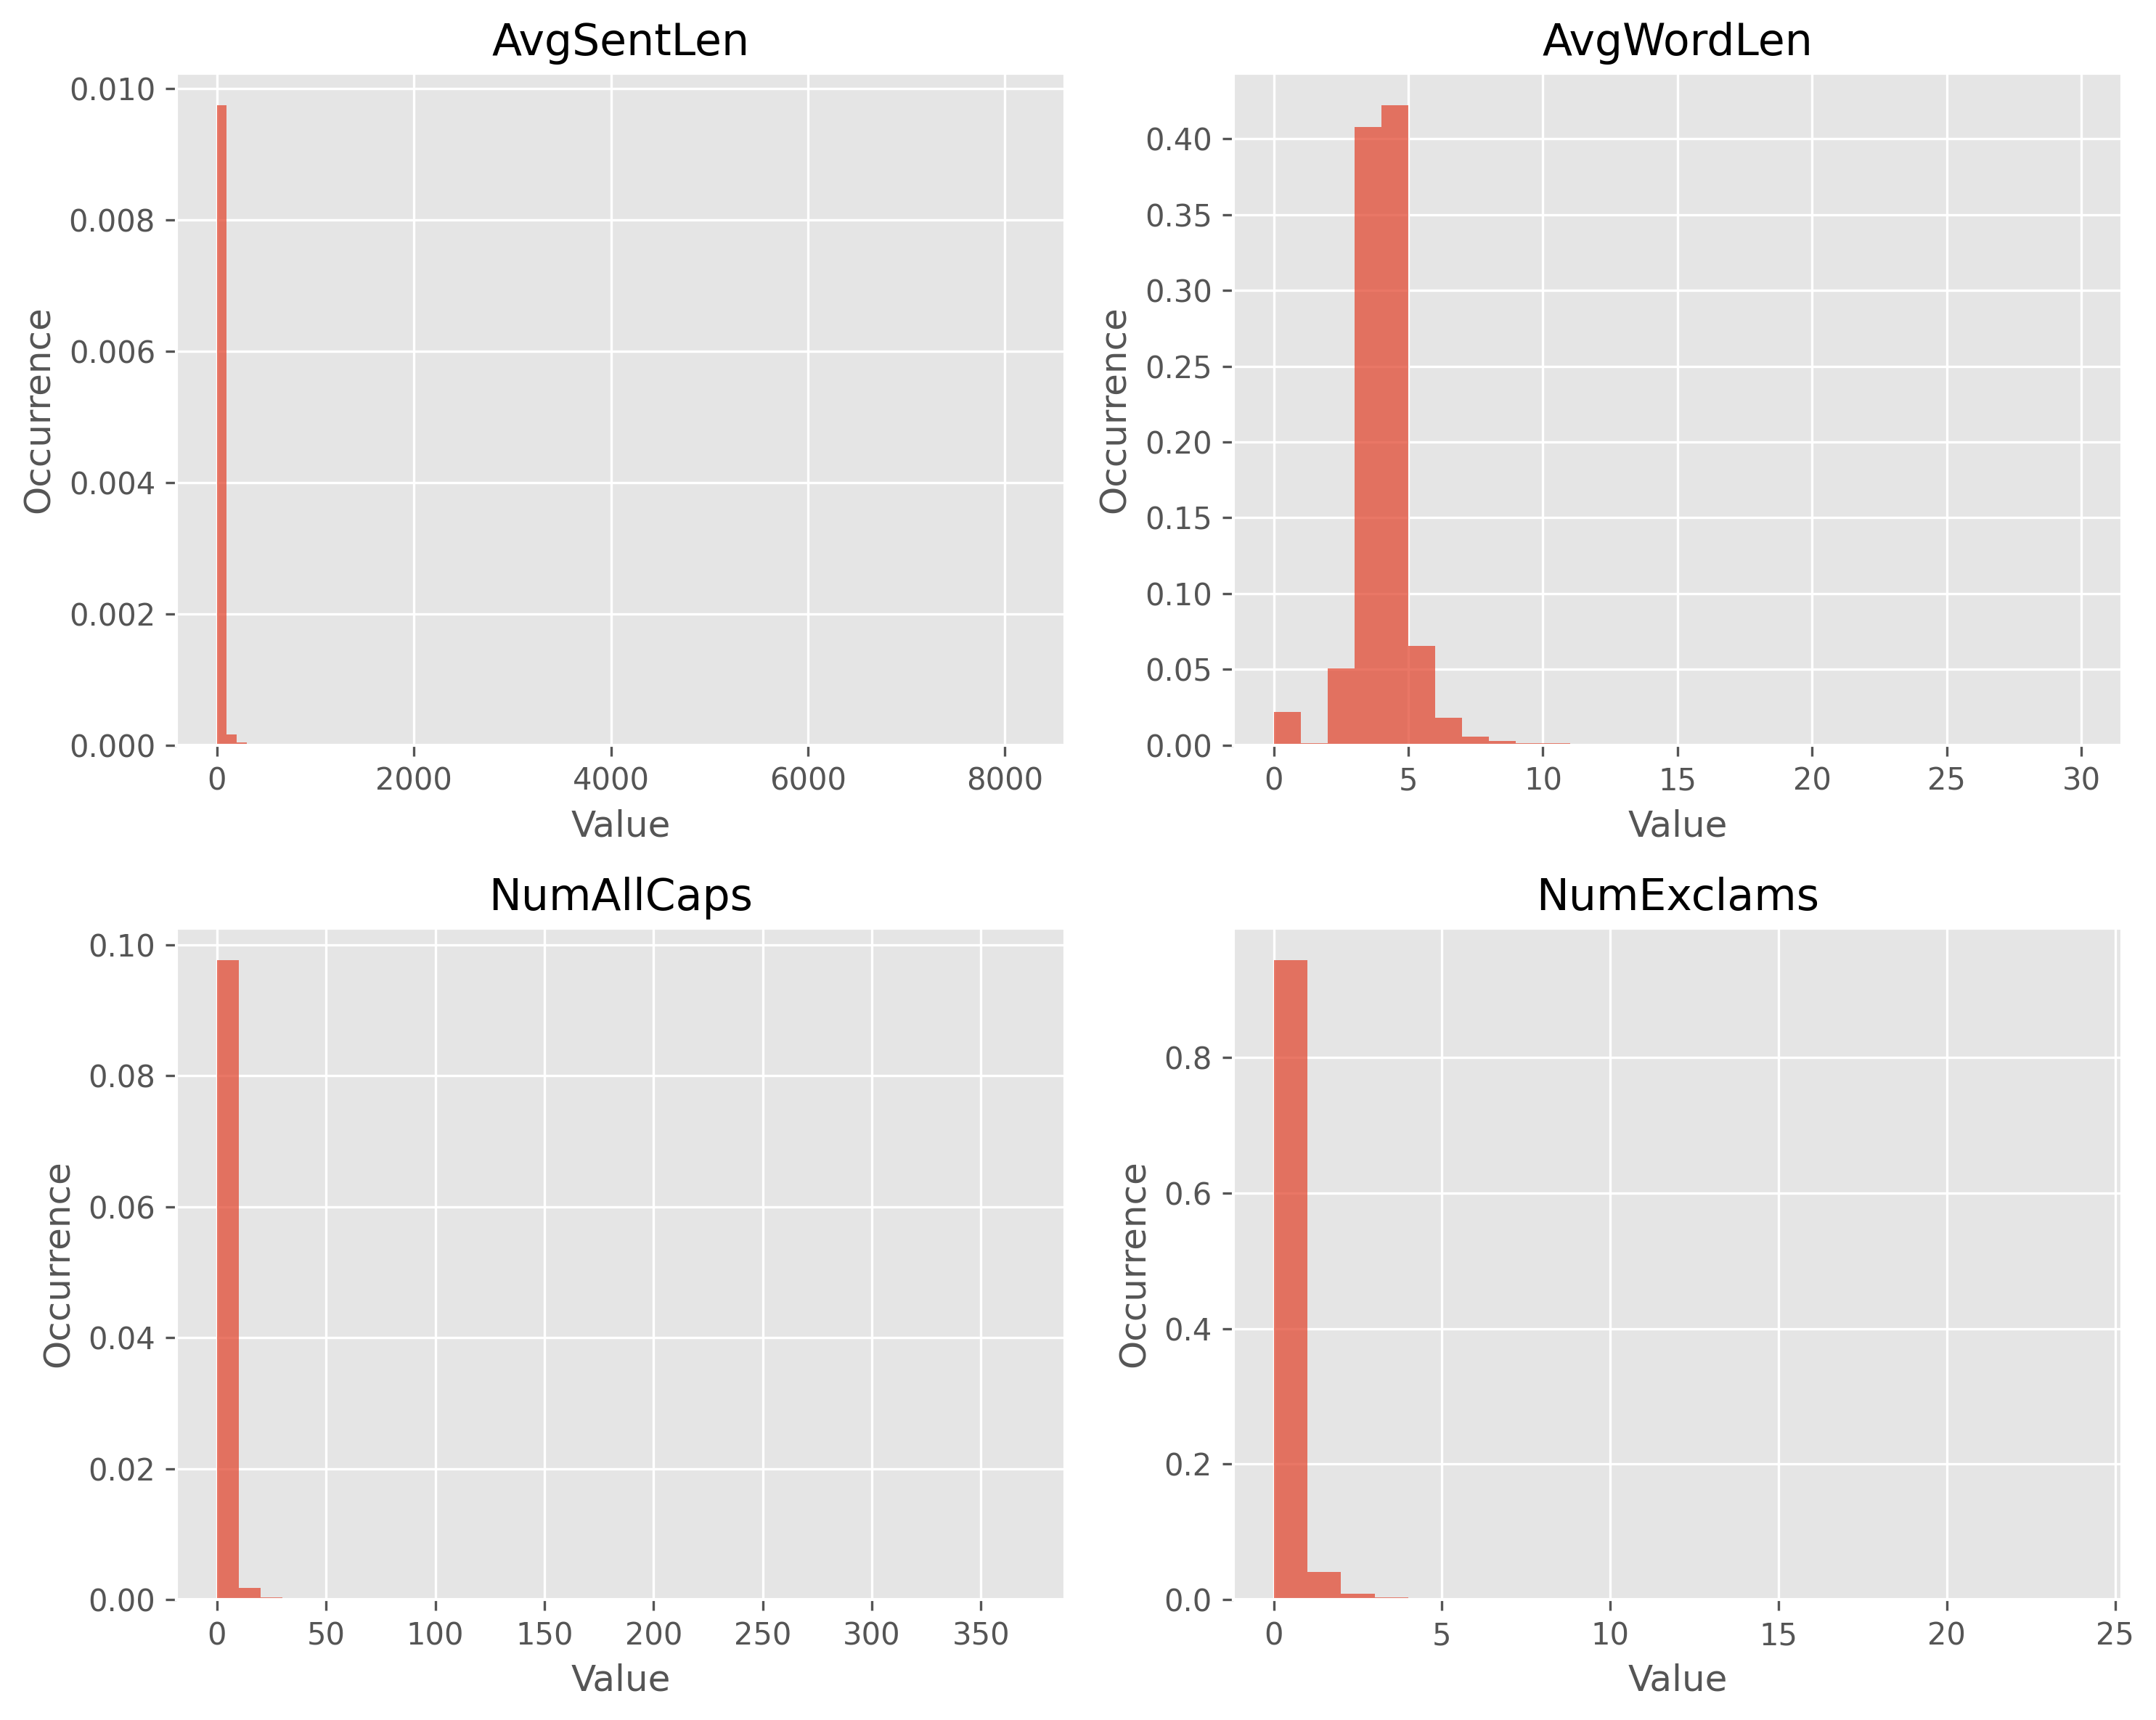

In [ ]:
import nltk
nltk.download('punkt')
def fetch_post(fn):
  for line in open(fn, 'r', encoding = 'utf-8'):
    post_id, text = line.split('\t')
    yield int(post_id), text.strip()
# add more features to meta
def add_sentence_features(m):
  for pid, text in fetch_post(fn_sample):
    if not text:
      for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']:
        m[pid][feat] = 0
    else:
      sent_lens = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
      m[pid]['AvgSentLen'] = np.mean(sent_lens)
      text_tokens = nltk.word_tokenize(text)
      m[pid]['AvgWordLen'] = np.mean([len(w) for w in text_tokens])
      m[pid]['NumAllCaps'] = np.sum([word.isupper() for word in text_tokens])
      m[pid]['NumExclams'] = text.count('!')

add_sentence_features(meta)

plot_feat_hist([(np.asarray([[meta[aid][feat]] for aid in all_answers],
                            dtype=int), feat) for feat in [
                                'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']],
              '03_feat_hist_AvgSentLen_AvgWordLen_NumAllCaps_NumExclams')




In [ ]:
x = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens',
                            'AvgSentLen', 'AvgWordLen', 'NumAllCaps',
                            'NumExclams']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total = N_FOLDS):
  clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
  clf.fit(X[train], Y[train])
  scores.append(clf.score(X[test], Y[test]))

print('Mean(scores)=%.5f\tStddev(scores)=%.5f'% (np.mean(scores), np.std(scores)))


  0%|          | 0/10 [00:00<?, ?it/s]

Mean(scores)=0.59835	Stddev(scores)=0.01093


# High or low bias?

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

def plot_bias_variance(data_size, train_errors, test_errors, name, title):
  plt.figure(num = None, figsize = (6,5), dpi = 300)
  plt.ylim([0.0, 1.0])
  plt.xlabel('Data set Size')
  plt.ylabel('Error')
  plt.title("Bias-Variance for '%s'" % name)
  plt.plot(data_size, test_errors, '--', data_size,  train_errors, 'b-', lw=1)
  plt.legend(['test error', 'train error'], loc = 'upper right')
  plt.grid(True)

def plot_pr(auc_score, name, precision, recall, label = None):
  plt.figure(num=None, figsize=(6,5), dpi=300)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.tilte('P/R (AUC=%0.2f) / %s' % (auc_score, label))
  plt.fill_between(recall, precision, alpha=0.5)
  plt.grid(True)
  plt.plot(recall, precision, lw=1)
  filename = name.replace(' ', '_')+'_pr'
  save_png(filename)

def plot_feat_importance(feature_names, clf, name):
  plt.figure(num=None, figsize=(6, 5), dpi=300)
  coef_ = clf.coef_
  important = np.argsort(np.absolute(coef_.ravel()))
  f_imp = feature_names[important]
  coef = coef_.ravel()[important]
  inds = np.argsort(coef)
  f_imp = f_imp[inds]
  coef = coef[inds]
  xpos = np.array(list(range(len(coef))))
  plt.bar(xpos, coef, width=1, alpha=0.75)

  plt.title('Feature importance for %s' % (name.split('_')[-1]))
  ax = plt.gca()
  ax.set_xticks(np.arange(len(coef)))
  labels = ax.set_xticklabels(f_imp)
  for label in labels:
    label.set_rotation(90)
  filename = name.replace(' ', '_')+'_feat_imp'
  save_png(filename)

def measure(clf_class, parameters, name, X, Y, data_size=None, plot=None, features_names=None ):
  if data_size is not None:
    X = X[:data_size]
    Y = Y[:data_size]

  train_errors = []
  test_errors = []
  score =[]
  roc_scores = []
  fprs, tprs = [], []
  pr_scores = []
  precisions, recalls, thresholds = [], [], []

  for fold_idx, (train, test) in enumerate (cv.split(X,Y)):
    X_train, Y_train = X[train], Y[train]
    X_test, Y_test = X[test], Y[test]

    only_one_class_in_train = len(set(Y_train)) == 1
    only_one_class_in_test = len(set(Y_test)) == 1
    if only_one_class_in_train or only_one_class_in_test:
      # this would pose problems later on
      continue
    clf = clf_class(**parameters)

    clf.fit(X_train, Y_train)

    train_score = clf.score(X_train, Y_train)
    test_score = clf.score(X_test, Y_test)

    train_errors.append(1 - train_score)
    test_errors.append(1 - test_score)

    scores.append(test_score)
    proba = clf.predict_proba(X_test)

    label_idx = 1
    fpr, tpr, roc_thresholds = roc_curve(Y_test,proba[:, label_idx])
    precision, recall, pr_thresholds = precision_recall_curve(Y_test, proba[:, label_idx])

    roc_scores.append(auc(fpr, tpr))
    fprs.append(fpr)
    tprs.append(tpr)

    pr_scores.append(auc(recall, precision))
    precisions.append(precision)
    recalls.append(recall)
    thresholds.append(pr_thresholds)

    # This threshold is determined at the end of the chapter,
    # where we find conditions such that precision is in the are of
    # about 80%, With it we trade off recall for precision.
    trhreshold_for_detecting_good_answer = 0.59

    if False:
      print('Clone#%i' % fold_idx)
      print(classification_report(Y_test, proba[:, label_idx]) >
            threshold_for_detecting_good_answers, target_names = ['not accepted', 'accepted'])
      # get medium clone
  scores_to_sort = pr_scores # roc_scores
  medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
  # print ('Medium clone is #%i' % medium)

  if plot:
    # plt_roc(roc_socres[medium], name, fprs[medium], tprs[medium])
    plot_pr(pr_scores[medium], name, precisions[medium],
            recalls[medium], plot + 'answers')

    if hasattr(clf, 'coef_'):
      plot_feat_importance(feature_names, clf, name)
    elif hasattr(clf, 'name_steps'):
      for step, s_clf in clf.named_steps.items():
        if hasattr(s_clf, 'coef_'):
          plot_feat_importance(feature_names, s_clf, name)

  summary = {'name': name, 'scores': scores,
             'roc_scores': roc_scores,
             'pr_scores': pr_scores,
             'med_precisions': precisions[medium],
             'med_recalls': recall[medium],
             'med_thresholds': thresholds[medium]}

  return np.mean(train_errors), np.mean(test_errors), summary

def bias_variance_analysis(clf_class, parameters, name, X, Y):
  data_sizes = np.arange(40, 2000, 20)
  train_errors = []
  test_errors = []

  for data_size in data_sizes:
    train_error, test_error, _ = measure(clf_class, parameters, name, X, Y, data_size=data_size)
    train_errors.append(train_error)
    test_errors.append(test_error)

  plot_bias_variance(data_sizes, train_errors, test_errors, name, "Bias-Variance for '%s'" % name)

As we have learned in the previous chapter, when using features with different value ranges, it hleps to standardize them

In [ ]:
def create_pipeline(**param):
  return make_pipeline(StandardScaler(), KNeighborsClassifier(**param))

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, '5NN', X, Y )
save_png('04_bv_5NN_all')


IndexError: ignored

Maybe simplifying the feature space helps. Let's try out to use only LinkCount and NumTextTokens:

In [ ]:
from sklearn.utils import shuffle
X_simp = np.asarray([get_features(aid, ['LinkCount', 'NumTextTokens']) for aid in all_answers],
                    float)
X_simp, Y_simp = shuffle(X_simp, Y, random_state = 0)

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, '5NN', X_simp, Y_simp)
save_png('05_bv_5NN_simp')


Does it help to reduce the model complexity by increasing k?

In [ ]:
print('k\tmean(scores)\tstddev(scores)')
for k in [5, 10, 40]:
  _, _, summary = measure(create_pipeline, {'n_neighbors': k}, '%iNN' % k, X, Y)
  print('%d\t%.4f\t\t%.4f' % (k, np.mean(summary['scores']), np.std(summary['scores'])))


It helps a bit, but do we really want to compare with 40 different samples each time?

In [ ]:
def plot_k_complexity(ks, train_errors, test_errors):
  plt.figure(num=None, figsize = (6,5), dpi = 300)
  plt.ylim([0.0, 1.0])
  plt.xlabel('$k$')
  plt.ylabel('Error')
  plt.title('Errors for different values of $k$')
  plt.plot(ks, test_errors, '--', ks, train_errors, '-', lw=1)
  plt.legend(['test error', 'train error'], loc='upper right')
  plt.grid(True)
  save_png('06_kcomplexity')

def k_complexity_analysis(clf_class, X, Y):
  # Measure for different K's: [1,2,....,20,25,..,100]
  ks= np.hstack((np.arange(1,21), np.arange(25, 101, 5)))

  train_errors = []
  test_errors = []

  for k in ks:
    train_error, test_error, _ = measure(clf_class, {'n_neighbors': k}, '%dNN' % k, X, Y,
                                         data_size = 2000)
    train_errors.append(train_error)
    test_errors.apped(test_error)

  plot_k_complexity(ks, train_errors, test_errors)

k_complexity_analysis(create_pipeline, X, Y)

NameError: ignored